In [1]:
import os
import numpy as np
import pysindy as ps
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso

In [2]:
# Amount of networks to generate
nets = 50

# Generation Options
nodes = 10000
edges = 2

# Networks
graphs = []

for net in range(nets):
    G = nx.generators.random_graphs.barabasi_albert_graph(nodes, edges)
    graphs += [G]

In [3]:
# Get average degree
avg_degree = np.zeros((nodes, nodes))
for idx, G in enumerate(graphs):
    print('Graph', idx)
    # Degrees through time
    degrees_t = np.zeros((nodes, nodes))
    for num, t in tqdm(enumerate(degrees_t)):
        index = range(num+1)
        H = G.subgraph(index)
        degrees_sub = np.fromiter(dict(nx.degree(H)).values(), dtype=int)
        degrees_t[num] = np.pad(degrees_sub, (0, nodes - num - 1), 'constant', constant_values=0)
    avg_degree += degrees_t
avg_degree /= nets

Graph 0


10000it [05:27, 30.50it/s]


Graph 1


10000it [04:44, 35.15it/s]


Graph 2


10000it [04:47, 34.77it/s]


Graph 3


10000it [04:50, 34.37it/s]


Graph 4


10000it [04:46, 34.90it/s]


Graph 5


10000it [04:47, 34.80it/s]


Graph 6


10000it [04:48, 34.72it/s]


Graph 7


10000it [04:22, 38.07it/s]


Graph 8


10000it [04:23, 38.02it/s]


Graph 9


10000it [04:21, 38.24it/s]


Graph 10


10000it [04:42, 35.42it/s]


Graph 11


10000it [05:03, 32.98it/s]


Graph 12


10000it [04:39, 35.78it/s]


Graph 13


10000it [04:22, 38.04it/s]


Graph 14


10000it [04:22, 38.07it/s]


Graph 15


10000it [04:29, 37.11it/s]


Graph 16


10000it [04:42, 35.36it/s]


Graph 17


10000it [04:24, 37.77it/s]


Graph 18


10000it [04:19, 38.50it/s]


Graph 19


10000it [04:19, 38.50it/s]


Graph 20


10000it [04:19, 38.54it/s]


Graph 21


10000it [04:21, 38.22it/s]


Graph 22


10000it [04:22, 38.11it/s]


Graph 23


10000it [04:24, 37.75it/s]


Graph 24


10000it [04:23, 37.92it/s]


Graph 25


10000it [04:20, 38.32it/s]


Graph 26


10000it [04:23, 38.00it/s]


Graph 27


10000it [04:24, 37.88it/s]


Graph 28


10000it [04:21, 38.20it/s]


Graph 29


10000it [04:21, 38.24it/s]


Graph 30


10000it [04:20, 38.39it/s]


Graph 31


10000it [04:22, 38.12it/s]


Graph 32


10000it [04:19, 38.49it/s]


Graph 33


10000it [04:20, 38.37it/s]


Graph 34


10000it [04:20, 38.36it/s]


Graph 35


10000it [04:28, 37.30it/s]


Graph 36


10000it [04:29, 37.16it/s]


Graph 37


10000it [04:19, 38.47it/s]


Graph 38


10000it [04:22, 38.10it/s]


Graph 39


10000it [04:20, 38.44it/s]


Graph 40


10000it [04:21, 38.27it/s]


Graph 41


10000it [04:22, 38.13it/s]


Graph 42


10000it [04:35, 36.25it/s]


Graph 43


10000it [04:23, 38.02it/s]


Graph 44


10000it [04:26, 37.49it/s]


Graph 45


10000it [04:22, 38.06it/s]


Graph 46


10000it [04:30, 36.97it/s]


Graph 47


10000it [04:24, 37.83it/s]


Graph 48


10000it [04:21, 38.30it/s]


Graph 49


10000it [04:19, 38.55it/s]


In [4]:
# Get File Names
data_path = os.path.join(os.path.abspath(''), '..', 'Data', 'Generated', 'Barabasi')
save_path = os.path.join(data_path, 'Test_Network_50.npy')

with open(save_path, 'wb') as f:
    np.save(f, avg_degree)

In [5]:
t = np.arange(nodes)
avg_degree[:,0]

array([  0.  ,   1.  ,   2.  , ..., 190.98, 190.98, 190.98])

# Model Structure
The sparse recovery of the dynamics depend on the model defined for it. Such model is composed of a differentiation method to find the numerical derivative of the measured data, a features library that contains the set of basis functions that define the likely behaviour of the data, and an optimizer that defines the algorithms that performs the sparse regression to solve the approximation problem. With this context and following [Tips](https://pysindy.readthedocs.io/en/latest/tips.html) the following is chosen:

## Differentiation Method
Based on [Differentiation](https://pysindy.readthedocs.io/en/latest/examples/5_differentation.html), there are different available methods to compute:

![X \rightarrow  \dot{X}](https://latex.codecogs.com/svg.latex?X&space;\rightarrow&space;\dot{X})

Given the stepwise nature of the degree of a node in the network, since it grows in discrete amplitudes on discrete time, the Trend Filtered method was chose.

**TODO:**
- [ ] PySINDy Finite Difference: Forward & Centered
- [ ] Finite Difference
- [ ] Smoothed Finite Difference
- [ ] Savitzky Golay
- [ ] Spline
- [x] Trend Filtered
- [ ] Spectral

## Basis Set
SINDy assumes that the system dynamics can be represented as a sparse linear combination of the basis functions. A bad selection of a basis set leads to the assumption being violated and as such a resulting bad model (generally non-sparse). Based on this an ideal approach would be a basis set of functions that defines the likely nature; in this case some time-series basis set would be ideal. As an initial approach the Polynomial Library is used since such basis set requieres deeper insight into the data.

## Optimizer
For the optimizer an initial attempt with the sequentially-thresholded least-squares algorithm is simpler and future attempts with other methods (such as LASSO) can be done as a comparison.

In [6]:
model = ps.SINDy(
    differentiation_method=ps.SINDyDerivative(kind='trend_filtered', order=0, alpha=1e-2),
    feature_library=ps.PolynomialLibrary(degree=3),
    optimizer=ps.STLSQ(threshold=1e-5),
    feature_names=['K', 't']
)

In [7]:
# First column is the degree the second one is the time
# X = avg_degree[:,0]
X = np.stack((avg_degree[:,0], t[:]), axis=-1)
model.fit(X)

/local/anaconda3/envs/dddu/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.92262e-27): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/local/anaconda3/envs/dddu/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.92262e-27): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


SINDy(differentiation_method=SINDyDerivative(alpha=0.01, kind='trend_filtered',
                                             order=0),
      feature_library=PolynomialLibrary(degree=3), feature_names=['K', 't'],
      optimizer=STLSQ(threshold=1e-05))

In [9]:
model.print()

K' = 0.132 1 + -0.002 K
t' = 1.000 1


In [10]:
# Get vectors for plotting
k_mod = avg_degree[:,0]
k_sim = model.simulate([0,0], t=t)[:,0]

In [13]:
# Analytic approach
def barabasi(m, t, t_i):
    return m * np.sqrt(t / t_i)

t = np.arange(10000)
k_ant = barabasi(2, t, 1)

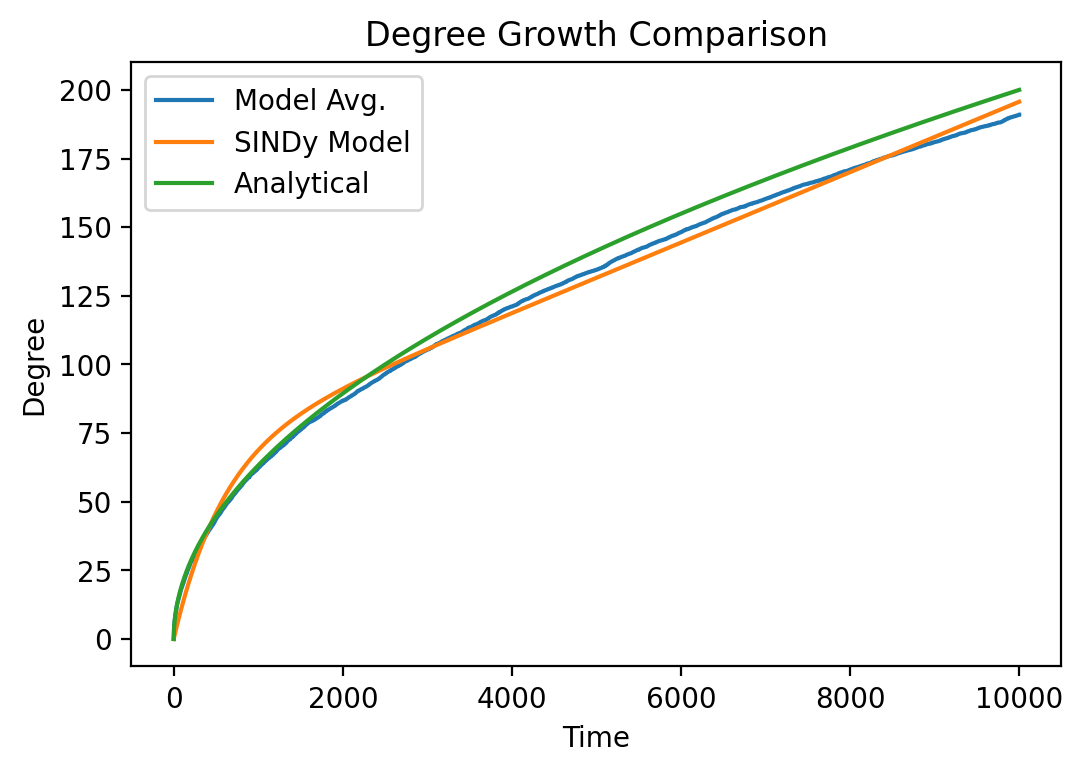

In [21]:
fig=plt.figure(figsize=(6,4), dpi= 200, facecolor='w', edgecolor='k')
plt.plot(t, k_mod)
plt.plot(t, k_sim)
plt.plot(t, k_ant)
plt.title('Degree Growth Comparison')
plt.xlabel('Time')
plt.ylabel('Degree')
plt.legend(['Model Avg.', 'SINDy Model', 'Analytical'])